# 배치할당  

**Info**  

슈트별 작업량(=품번*수량)이 동일하게 물품을 할당하는 알고리즘  
- 모든 슈트가 해방되어야 다음 작업이 수행되도록 구현
- 해방된 슈트는 먼저 다음 작업을 수행할 수 있도록 구현  
-> 2안은 작업시간을 고려하지 못하고,(실제로 동일한 작업량일지라도 작업 시간이 다를 수 있음) 또한 물품이 어떻게 슈트에 할당되는지 알 수 없기 때문에(알고리즘은 주문번호 그룹화로 진행) 실질적으로 사용에 한계가 있음.  
-> 1안은 작업량이 많은 순으로 슈트에 배분되기 때문에 앞선 작업이 더 많은 작업량이 할당됨. 즉, 슈트별 작업량은 균등하더라도 배치별 작업량은 균등하지 않음.  
  
**함수 설명:**  

*1안: 모든 슈트가 해방되어야 다음 배치 수행*
- release_and_process_orders(df, order, count, shut):
    - df: 불러온 원본 데이터
    - order: 주문번호
    - count: 수량
    - shut: 슈트 개수   
    
*2안: 슈트별 독립적으로 작업 할당*  
- process_order_with_released_suit(ddf, order, count, shut):
    - df: 불러온 원본 데이터
    - order: 주문번호
    - count: 수량
    - shut: 슈트 개수

In [33]:
# 변수 설정

# 칼럼명 고정, 출하일이 없어서 출고일로 대신 지정함.(바꿔서 사용 바람.)
order = '온라인 주문번호'
count = '수량'
sku = '품번'
date = '출고일'
# 슈트 개수
shut = 60

In [34]:
# 필요한 라이브러리와 데이터 불러오기
# 경로를 알맞게 입력해줘야 함.
import pandas as pd
import time
df = pd.read_excel('data/BA_Sample_Samsung_0421_raw_data.xlsx',usecols= [order,count,sku,date])

In [35]:
df

,출고일,품번,수량,온라인 주문번호
0,2022-04-21,111721BPAA070,1,OD202204211595605
1,2022-04-21,111871LY6RM,1,OD202204211595605
2,2022-04-21,121771DYAAM,1,OD202204211595605
3,2022-04-21,321751AY1LM,1,OD202204211595605
4,2022-04-21,321751LY2PM,1,OD202204211595605
...,...,...,...,...
14534,2022-04-21,192196WY75F,1,OD202204201590292
14535,2022-04-21,321821LH8KM,5,OD202204201590292
14536,2022-04-21,351525JQ2E070,1,OD202204201590292
14537,2022-04-21,351565JQ2EM,1,OD202204201590292


#### 알고리즘1: 모든 슈트 해방 후 일괄로 주문 처리 방식


1. 주문번호끼리 그룹화

2. 작업량 = 품번의 개수 * 수량 -> 그룹(주문번호)마다 작업량 계산

3. 작업량이 많은 순으로 정렬(내림차순)(=투입순서)

4. 각 슈트에는 아래와 같이 할당됨(숫자가 작을수록 우선순위, 작업량 많은 항목)(ㄹ모양)  
    <0> <1>          <58> <59>  
0-   0   1    ....    58   59   ->   1번 배치 (0\*60+i+1)   ->   y-0\*60  
1-  119 118   ....    61   60   ->   2번 배치 (2\*60-i)     ->   2\*60-1-y  
2-  120 121   ....   178  179   ->   3번 배치 (2\*60+i+1)   ->   y-2\*60

#### 생성결과

1. 투입 순서 + 배치 순서 

2. 배당되는 슈트

In [36]:
# 함수 정의 - 수정 불가
def release_and_process_orders(df, order, count, shut,date):
  start_time = time.time()
  for d_value, group in df.groupby(date):
    order_df = group.groupby(order)[count].sum().reset_index()
    order_df = order_df.sort_values(by=count, ascending=False).reset_index(drop=True)
    order_df['투입순서'] = order_df.index
    order_df['배치'] = order_df.index // shut
  
    for i in range(len(order_df)):
      if (order_df.loc[i, '배치'] % 2 == 1):
          order_df.loc[i, '슈트'] = shut*(order_df.loc[i, '배치']+1)-i-1
      else:
          order_df.loc[i, '슈트'] = i- order_df.loc[i, '배치']*shut
    order_df.to_csv(f'orders_{d_value}.csv', index=False)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"총 소요 시간: {elapsed_time:.2f}초")
  print("모든 주문 해방 후 일관되게 주문을 처리하는 방식으로 날짜별 파일에 저장되었습니다.")

In [37]:
# 함수 실행
release_and_process_orders(df, order, count, shut,date)

               온라인 주문번호  수량  투입순서  배치   슈트
0     OD202204211605517  69     0   0  0.0
1     OD202204211596980  45     1   0  1.0
2     OD202204211596072  37     2   0  2.0
3     OD202204211604990  34     3   0  3.0
4     OD202204201592352  32     4   0  4.0
...                 ...  ..   ...  ..  ...
3111  OD202204211604937   1  3111  51  8.0
3112  OD202204201591190   1  3112  51  7.0
3113  OD202204211601155   1  3113  51  6.0
3114  OD202204201590428   1  3114  51  5.0
3115  OD202204201590512   1  3115  51  4.0

[3116 rows x 5 columns]
총 소요 시간: 0.13초
모든 주문 해방 후 일관되게 주문을 처리하는 방식으로 날짜별 파일에 저장되었습니다.


#### 알고리즘2: 하나의 슈트가 해방될 경우 해당 슈트는 다음 주문 처리


1. 주문번호끼리 그룹화

2. 작업량 = 품번의 개수 * 수량 -> 그룹(주문번호)마다 작업량 계산

3. 총작업량 계산 후 각 슈트당 작업량 할당

4. 작업을 남아있는 작업량이 가장 많은 슈트에 할당, 남아있는 작업량 업데이트

In [38]:
# 함수 정의 - 수정 불가
def process_order_with_released_suit(df, order, count, shut,date):
    start_time = time.time()
    for d_value,group in  df.groupby(date):
      order_df = df.groupby(order)[count].sum().reset_index()
      current_workload = [order_df['수량'].sum()/shut]*shut
      for i in range(len(order_df)):
          index = current_workload.index(max(current_workload))
          order_df.loc[i, '슈트'] = index
          current_workload[index] -= order_df.loc[i, count]
      order_df.to_csv(f'orders_{d_value}2.csv', index=False)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"총 소요 시간: {elapsed_time:.2f}초")
    print("하나의 슈트가 해방될 경우 해당 슈트는 다음 주문 처리하는 방식으로 'orders2.csv' 파일에 저장되었습니다.")

In [39]:
# 함수 실행
process_order_with_released_suit(df, order, count, shut,date)

               온라인 주문번호  수량    슈트
0     OD202204091413193   3   0.0
1     OD202204121453868   2   1.0
2     OD202204131475710   3   2.0
3     OD202204131476387   2   3.0
4     OD202204131480783   2   4.0
...                 ...  ..   ...
3111  OD202204211607081  11   7.0
3112  OD202204211607083   6   8.0
3113  OD202204211607084   3   9.0
3114  OD202204211607085   5  18.0
3115  OD202204211607087   7  21.0

[3116 rows x 3 columns]
총 소요 시간: 0.14초
하나의 슈트가 해방될 경우 해당 슈트는 다음 주문 처리하는 방식으로 'orders2.csv' 파일에 저장되었습니다.


### 기존 방법과 비교  
- 아래부터는 실행 필요 없음.  
- 작업량 균등 분배가 개선됨을 확인하는 용도.

In [11]:
origin = pd.read_excel("data/BA_Sample_Samsung_0421_verificated_1.xlsx",usecols=['온라인주문번호의 순서','60슈트씩','수량'],sheet_name="출하_4월21일자")
origin

,수량,온라인주문번호의 순서,60슈트씩
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
14534,1,3116,52
14535,5,3116,52
14536,1,3116,52
14537,1,3116,52


In [12]:
order_origin = origin.groupby('온라인주문번호의 순서')['수량'].sum().reset_index()
order_origin

,온라인주문번호의 순서,수량
0,1,10
1,2,10
2,3,5
3,4,2
4,5,4
...,...,...
3111,3112,4
3112,3113,4
3113,3114,2
3114,3115,2


In [13]:
workload_origin = []
for s in range(shut):
    workload_origin.append(order_origin[order_origin['온라인주문번호의 순서']%shut ==s]['수량'].sum())
print(workload_origin)

[257, 245, 242, 268, 232, 284, 258, 245, 242, 263, 198, 282, 272, 273, 241, 279, 275, 231, 268, 243, 233, 235, 259, 286, 268, 207, 223, 246, 237, 247, 228, 251, 263, 231, 277, 284, 250, 241, 249, 229, 301, 230, 219, 256, 245, 234, 204, 235, 239, 214, 254, 282, 291, 229, 237, 239, 232, 260, 250, 221]


In [14]:
import numpy as np
# 1번 방식
print(np.var(workload))
print(np.var(workload_origin))

49.44555555555555
505.4455555555555


In [28]:
# 2번 방식
print(np.var(workload))

45.07888888888888


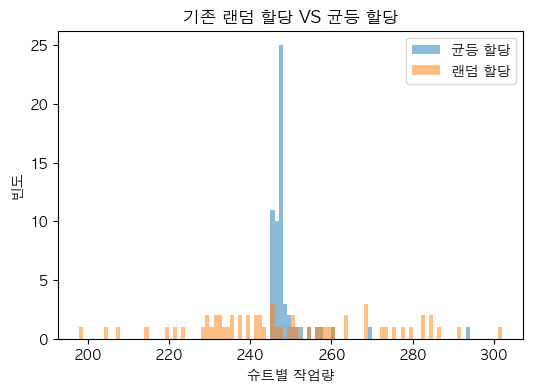

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import rc

rc('font', family='AppleGothic')

workload_counter = Counter(workload)
workload_origin_counter = Counter(workload_origin)

values_workload = list(workload_counter.elements())
values_workload_origin = list(workload_origin_counter.elements())
plt.figure(figsize=(6, 4))

plt.hist(values_workload, bins=range(min(values_workload + values_workload_origin), max(values_workload + values_workload_origin) + 2), alpha=0.5, label='균등 할당')
plt.hist(values_workload_origin, bins=range(min(values_workload + values_workload_origin), max(values_workload + values_workload_origin) + 2), alpha=0.5, label='랜덤 할당')

plt.xlabel('슈트별 작업량')
plt.ylabel('빈도')
plt.title('기존 랜덤 할당 VS 균등 할당')
plt.legend(loc='upper right')

plt.show()